This is the second of a short series of posts providing brief introductions to new functionality in the RDKit 2024.09.1 release (added since the 2024.03.1 release).

In [2]:
import rdkit
rdkit.__version__

'2024.09.1'

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# Improvements to RMS filtering in conformer generation

Here's a simple molecule for demonstration purposes:

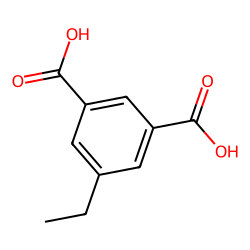

In [36]:
IPythonConsole.molSize = 250,250
m = Chem.MolFromSmiles('CCc1cc(C(=O)O)cc(C(=O)O)c1')
m

In [37]:
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign

mh = Chem.AddHs(m)
ps = rdDistGeom.srETKDGv3()
ps.randomSeed = 0xa100f
cids = rdDistGeom.EmbedMultipleConfs(mh,100,ps)
print(len(cids))

100


In [4]:
import py3Dmol
def drawit(ms, p=None, confIds=None, removeHs=False,colors=('cyanCarbon','blueCarbon','redCarbon')):
        if confIds is None:
            confIds = [-1]*len(ms)
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,(m,confId) in enumerate(zip(ms,confIds)):
            if removeHs:
                m = Chem.RemoveHs(m)
            IPythonConsole.addMolToView(m,p,confId=confId)
        for i,m in enumerate(ms):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

First a quick intro to the `symmetrizeConjugatedTerminalGroups` argument to `GetBestRMS()`

In [57]:
m1 = Chem.RemoveHs(Chem.Mol(mh,confId=1))
m2 = Chem.RemoveHs(Chem.Mol(mh,confId=0))
rms = rdMolAlign.GetBestRMS(m1,m2,symmetrizeConjugatedTerminalGroups=False)
print(f'{rms:.2f}')
drawit([m1,m2])


0.86


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

You can see here that one of the carboxylic acids is flipped. That's why the calculated RMSD is pretty high even though the overlay is quite good.

Using `symmetrizeConjugatedTerminalGroups=True` (which is the default), the RMSD calculate treats the two oxygens of the carboxylic acid as equivalent and we get a much lower RMSD value:

In [40]:
rms = rdMolAlign.GetBestRMS(m1,m2)
print(f'{rms:.2f}')


0.08


If we look across a varietyof conformer pairs we can see that this frequently makes a difference in the RMSDs:

In [41]:
for i in range(5):
    for j in range(i):
        m1 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[i]))
        m2 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[j]))
        rms1 = rdMolAlign.GetBestRMS(m1,m2)
        rms2 = rdMolAlign.GetBestRMS(m1,m2,symmetrizeConjugatedTerminalGroups=False)
        print(f'{i}, {j}: {rms1:.2f}, {rms2:.2f}')


1, 0: 0.08, 0.86
2, 0: 0.08, 0.86
2, 1: 0.09, 0.09
3, 0: 0.06, 0.85
3, 1: 0.08, 0.08
3, 2: 0.04, 0.04
4, 0: 0.08, 0.86
4, 1: 0.07, 0.58
4, 2: 0.12, 0.58
4, 3: 0.10, 0.58


The `symmetrizeConjugatedTerminalGroups` option was added (and made the default) in the 2022.09.1 release of the RDKit. In the 2024.03.1 release we added support for this behavior to the RMSD pruning done during conformer generation and made it the default.

So if we turn on RMSD pruning for our simple test molecule, we now get only one conformer:

In [42]:
ps = rdDistGeom.srETKDGv3()
ps.randomSeed = 0xa100f
ps.pruneRmsThresh = 0.5
cids = rdDistGeom.EmbedMultipleConfs(mh,10,ps)
print(len(cids))

1


The symmetrization can be disabled:

In [43]:
ps.symmetrizeConjugatedTerminalGroupsForPruning=False
cids = rdDistGeom.EmbedMultipleConfs(mh,10,ps)
print(len(cids))

3


# Interface fo the PubChem shape-based alignment code


The PubChem team has recently published [pubchem-align3d](https://github.com/ncbi/pubchem-align3d/), an open-source library for doing fast shape-based alignment of molecules.

We've put an RDKit wrapper around this and added it as an optional RDKit feature.

The API here is likely to evolve over the next couple of releases.

Start by reading in a set of test molecules. We're using one of the sets from the paper "An Extensive and Diverse Set of Molecular Overlays for the Validation of Pharmacophore Programs" by [Ilena Giangreco and coworkers](https://doi.org/10.1021/ci400020a)

[07:11:49] Explicit valence for atom # 21 C, 5, is greater than permitted
[07:11:49] ERROR: Could not sanitize molecule ending on line 1352
[07:11:49] ERROR: Explicit valence for atom # 21 C, 5, is greater than permitted


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

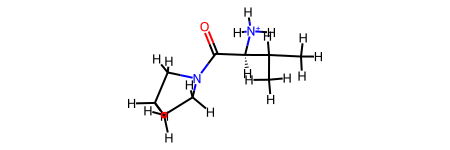

In [5]:
import gzip
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

ms = [x for x in Chem.ForwardSDMolSupplier(gzip.open('../data/AZ_overlays/P27487.sdf.gz'),removeHs=False) if x is not None]
len(ms)

ref = ms.pop(0)
ref

Generate conformers for each of the molecules so that we have something to align

In [8]:
ps = rdDistGeom.srETKDGv3()
ps.randomSeed = 0xa100f
ps.numThreads = 8
for m in ms:
    rdDistGeom.EmbedMultipleConfs(m,100,ps)

In [9]:
len(ms)

37

Make a copy of the molecules so that we can play with them

In [10]:
import copy
ms_save = copy.deepcopy(ms)

In [11]:
ms = copy.deepcopy(ms_save)

Look at the two molecules to align, just to see where we are starting.

In [12]:
drawit([ref,ms[0]])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Now align those and show the results:

In [13]:
from rdkit.Chem import rdShapeAlign
tpl = rdShapeAlign.AlignMol(ref,ms[0])
print(tpl)

drawit([ref,ms[0]])

(0.4333876003130784, 0.03657366774970186)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Find the conformer from each molecule that aligns with the highest feature score (the code calls it "color" score in analogy to the terminology that's used in ROCS) and see how long that takes.

In [20]:
import time
ms = copy.deepcopy(ms_save)
t1 = time.time()
nAligns = 0
bestScores = []
for m in ms:
    best = -1e8
    bestConf = -1
    for conf in m.GetConformers():
        nAligns += 1
        shapeTani,colorTani = rdShapeAlign.AlignMol(ref,m,probeConfId=conf.GetId())
        if colorTani > best:
            best = colorTani
            bestConf = conf.GetId()
    bestScores.append((best,bestConf))
t2 = time.time()
print(f'{t2-t1:.2f} seconds for {nAligns} alignments, {(t2-t1)/nAligns:.2g}s per alignment')

1.50 seconds for 3700 alignments, 0.0004s per alignment


In [21]:
order = sorted([(tpl,i) for i,tpl in enumerate(bestScores)],reverse=True)
order[:5]


[((0.41623472182088234, 53), 10),
 ((0.38375118479238873, 83), 14),
 ((0.343586129348326, 5), 1),
 ((0.3286720498960583, 87), 17),
 ((0.305952661317346, 20), 13)]

In [22]:
whichMol = order[0][-1]
bestConf = bestScores[whichMol][1]

print(bestScores[whichMol])
drawit([ref,ms[whichMol]],confIds=(-1,bestConf))

(0.41623472182088234, 53)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Since the reference molecule remains the same in each of these alignments, we can save a bit of time by precomputing the shape of the reference:

In [23]:
ms = copy.deepcopy(ms_save)

t1 = time.time()
refShape = rdShapeAlign.PrepareConformer(ref)

nAligns = 0
bestScores = []
for m in ms:
    best = -1e8
    bestConf = -1
    for conf in m.GetConformers():
        nAligns += 1
        shapeTani,colorTani = rdShapeAlign.AlignMol(refShape,m,probeConfId=conf.GetId())
        if colorTani > best:
            best = colorTani
            bestConf = conf.GetId()
    bestScores.append((best,bestConf))
t2 = time.time()
print(f'{t2-t1:.2f} seconds for {nAligns} alignments, {(t2-t1)/nAligns:.2g}s per alignment')

1.35 seconds for 3700 alignments, 0.00036s per alignment


This, of course, does not change the results:

In [24]:
order = sorted([(tpl,i) for i,tpl in enumerate(bestScores2)],reverse=True)
order[:5]

[((0.41623472182088234, 53), 10),
 ((0.38375118479238873, 83), 14),
 ((0.343586129348326, 5), 1),
 ((0.3286720498960583, 87), 17),
 ((0.305952661317346, 20), 13)]

## About the features

The default feature definitions used for scoring the alignments are a slightly modified version of the [Gobbi and Poppinger](https://doi.org/10.1002/(SICI)1097-0290(199824)61:1<47::AID-BIT9>3.0.CO;2-Z) features used elsewhere in the RDKit.

If the molecules have property
that [PubChem3D](https://pubchem.ncbi.nlm.nih.gov/docs/pubchem3d) uses to indicate pharmacophore features - `PUBCHEM_PHARMACOPHORE_FEATURES` -  those features will be used instead.

Here's an example showing this with conformers downloaded from PubChem3D:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

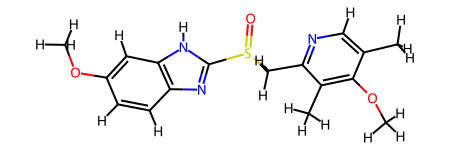

In [30]:
import requests
sdf = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/conformers/000011F200000003/SDF').content
suppl = Chem.SDMolSupplier()
suppl.SetData(sdf,removeHs=False)
omeprazole = next(suppl)
omeprazole

Look at the feature definitions;

In [33]:
print(omeprazole.GetProp('PUBCHEM_PHARMACOPHORE_FEATURES'))

9
1 2 acceptor
1 3 acceptor
1 4 acceptor
1 5 donor
1 7 acceptor
3 5 6 11 cation
5 5 6 11 12 14 rings
6 12 14 17 19 20 21 rings
6 7 9 10 13 15 18 rings


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

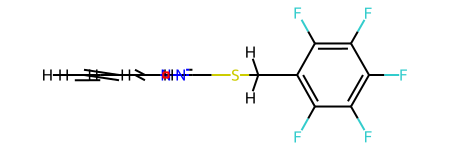

In [31]:
sdf = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/conformers/0005DA1100000001/SDF').content
suppl = Chem.SDMolSupplier()
suppl.SetData(sdf,removeHs=False)
mol = next(suppl)
mol

In [34]:
print(mol.GetProp('PUBCHEM_PHARMACOPHORE_FEATURES'))

5
1 7 donor
3 7 8 13 cation
5 7 8 11 12 13 rings
6 11 12 16 17 21 22 rings
6 9 14 15 18 19 20 rings


Align the molecules:

In [36]:
shapeTani,colorTani = rdShapeAlign.AlignMol(omeprazole,mol)
print(shapeTani,colorTani)
drawit([omeprazole,mol])

0.8584853463904615 0.5117278196011656


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

If we remove the properties, the code uses the RDKit feature definitions, so we get a different feature score:

In [38]:
t1 = Chem.Mol(omeprazole)
t1.ClearProp('PUBCHEM_PHARMACOPHORE_FEATURES')
t2 = Chem.Mol(mol)
t2.ClearProp('PUBCHEM_PHARMACOPHORE_FEATURES')
shapeTani,colorTani = rdShapeAlign.AlignMol(t1,t2)
print(shapeTani,colorTani)
drawit([t1,t2])

0.8584733801282853 0.4440077489499693


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

As a final note, it's possible to disable the use of features in the scoring entirely:

In [39]:
shapeTani,colorTani = rdShapeAlign.AlignMol(t1,t2,useColors=False)
print(shapeTani,colorTani)
drawit([t1,t2])

0.8584733855324804 0.0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.